# Load data

In [ ]:
# import from local desktop
import pandas as pd

from google.colab import files


uploaded = files.upload()

filename = list(uploaded.keys())[0]

df = pd.read_csv(filename)

print(df.head)



Saving SPUdataset.csv to SPUdataset.csv
<bound method NDFrame.head of        YEAR  MONTH        Date        Transfer Station  COMMODITY        TONS  \
0      2009      5  05/04/2009  North Transfer Station    Garbage  131.514968   
1      2009      5  05/04/2009  South Transfer Station  Recycling  315.151139   
2      2009      5  05/05/2009  South Transfer Station    Garbage   69.426921   
3      2009      5  05/05/2009  South Transfer Station  Recycling  317.744168   
4      2009      5  05/05/2009  South Transfer Station   Organics  198.330000   
...     ...    ...         ...                     ...        ...         ...   
33211  2024     11  11/06/2024  South Transfer Station   Organics  347.490000   
33212  2024     11  11/09/2024  North Transfer Station    Garbage    6.690507   
33213  2024     11  11/14/2024  North Transfer Station   Organics   83.770416   
33214  2024     11  11/17/2024  South Transfer Station    Garbage    5.170384   
33215  2024     11  11/18/2024  North T

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io

# Replace with actual filename if needed
#filename = list(uploaded.keys())[0]  # gets the uploaded filename
#df = pd.read_csv(io.BytesIO(uploaded[filename]))


# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

## Finding the missing dates in raw data
# Create a range of dates from min to max in the raw dataframe
full_date_range = pd.date_range(start = df['Date'].min(), end =df['Date'].max(),freq='D')

# Get unique dates present in the raw df
available_dates = pd.Series(df['Date'].unique())

# Find which dates are missing
missing_dates = full_date_range.difference(available_dates)

# Print the missing dates
print(f"Number of missing daily dates in raw df: {len(missing_dates)}")
print("Missing dates:", missing_dates)

Number of missing daily dates in raw df: 6
Missing dates: DatetimeIndex(['2019-02-10', '2021-02-13', '2021-02-14', '2021-12-27',
               '2021-12-28', '2022-12-23'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
## Aggregation of multiple rows in a day to one row per day
# Aggregate TONS per day
daily_df = df.groupby('Date')['TONS'].sum().sort_index()
  # .sum() aggregating the multiple daily rows into 1 row per date
  # .sort_index() puts the resulting aggregated days in order by date

# Print sample
print(daily_df.head())


# Create a complete date range from min to max date
full_date_range = pd.date_range(start=daily_df.index.min(), end=daily_df.index.max(), freq='D')

# Reindex to full range (this introduces NaNs where dates are missing)
daily_df = daily_df.reindex(full_date_range)

# Check how many days are missing (i.e., now NaNs exist)
missing_days = daily_df.isna().sum()
print(f"Missing daily entries: {missing_days}")


Date
2009-03-30    676.516193
2009-03-31    800.380112
2009-04-01    831.304422
2009-04-02    685.229470
2009-04-03    891.144219
Name: TONS, dtype: float64
Missing daily entries: 6


In [ ]:
daily_df_filled = daily_df.fillna(0)


In [ ]:
## Aggregation of daily data to weekly data (7 day aggregation)
# Resample to weekly TONS - resample('W') creates 7 day long bin
weekly_tons = daily_df_filled.resample('W').sum()

# Now weekly_tons is ready for ARIMA or ML modeling
print(weekly_tons.head())
print(weekly_tons.tail())

# to see length and shape
print("Number of weekly entries:", len(weekly_tons))
print("Shape of weekly_tons:", weekly_tons.shape)


# Check for missing weeks
# (This will show how many weeks have NaN after resampling)
missing_weeks = weekly_tons.isna().sum()
print(f"Missing weekly entries: {missing_weeks}")


2009-04-05    3932.634451
2009-04-12    5610.526417
2009-04-19    5056.141010
2009-04-26    6075.933124
2009-05-03    5593.365713
Freq: W-SUN, Name: TONS, dtype: float64
2025-03-23    5173.616571
2025-03-30    5304.368211
2025-04-06    5705.570603
2025-04-13    2717.142798
2025-04-20    2754.842907
Freq: W-SUN, Name: TONS, dtype: float64
Number of weekly entries: 838
Shape of weekly_tons: (838,)
Missing weekly entries: 0


In [ ]:
# check type of weekly_tons
type(weekly_tons)


pandas.core.series.Series

## Plot of data weekly series: Tons

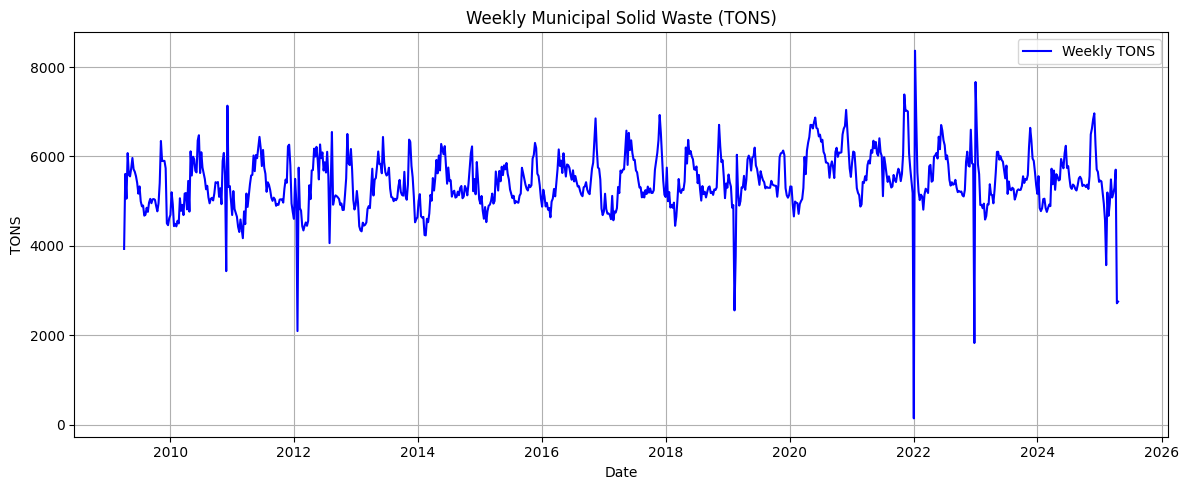

In [ ]:
import matplotlib.pyplot as plt

# Plot the weekly TONS time series
plt.figure(figsize=(12, 5))
plt.plot(weekly_tons.index, weekly_tons.values, label='Weekly TONS', color='blue')
plt.title('Weekly Municipal Solid Waste (TONS)')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Plot of daily

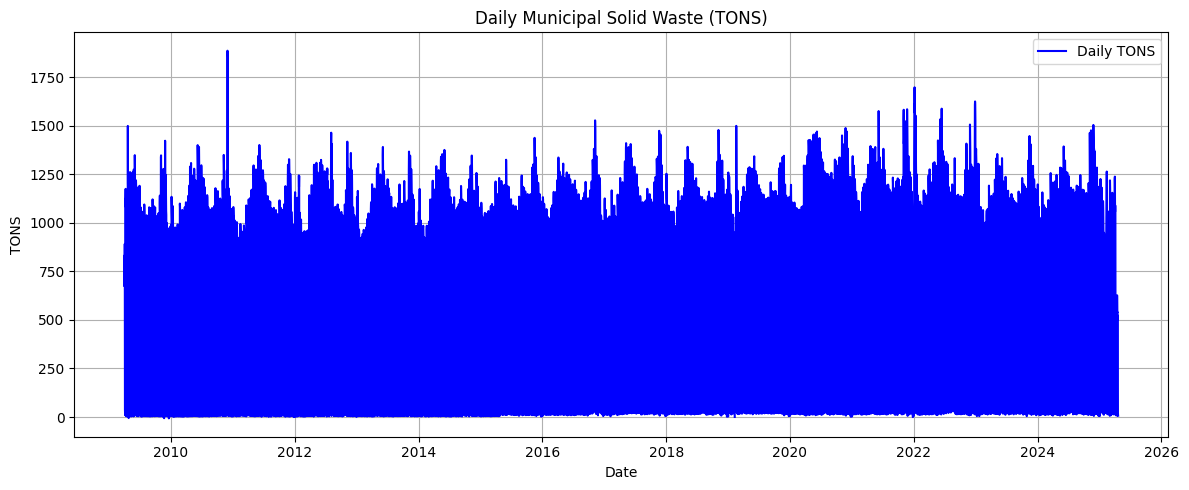

In [ ]:
import matplotlib.pyplot as plt

# Plot the daily TONS time series
plt.figure(figsize=(12, 5))
plt.plot(daily_df.index, daily_df.values, label='Daily TONS', color='blue')
plt.title('Daily Municipal Solid Waste (TONS)')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Plot of monthly series

<ipython-input-13-6728a4a0a989>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_tons = daily_df.resample('M').sum()


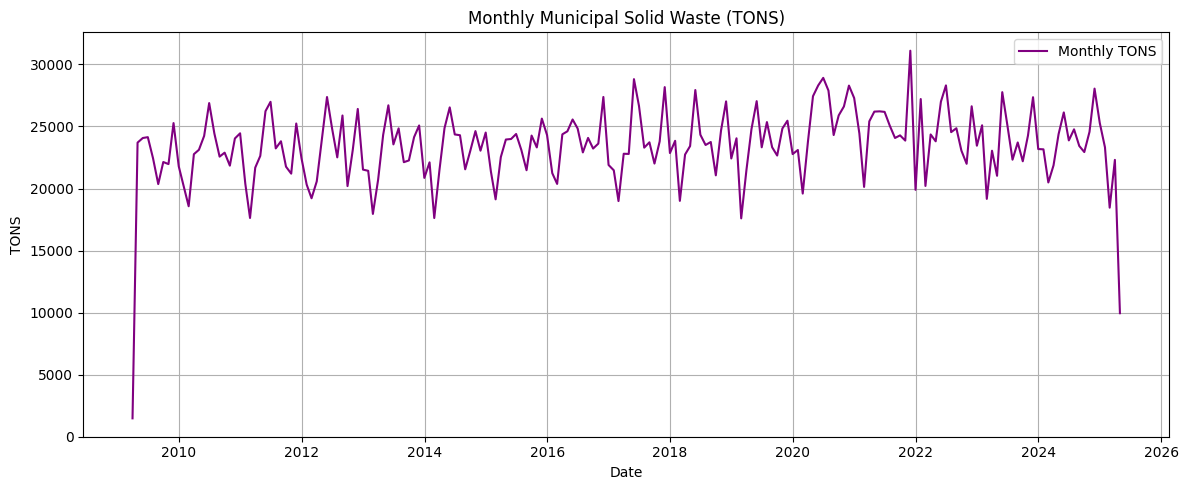

In [ ]:
# Aggregate daily data into monthly totals
monthly_tons = daily_df.resample('M').sum()

# Plot the monthly aggregated data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_tons.index, monthly_tons.values, label='Monthly TONS', color='purple')
plt.title('Monthly Municipal Solid Waste (TONS)')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
monthly_tons.head()

,TONS
2009-03-31,1476.896305
2009-04-30,23698.952743
2009-05-31,24069.046015
2009-06-30,24137.820970
2009-07-31,22435.147904


In [ ]:
print("Number of weekly entries:", len(weekly_tons))
print("Shape of weekly_tons:", weekly_tons.shape)
monthly_tons.shape

Number of weekly entries: 838
Shape of weekly_tons: (838,)


(194,)

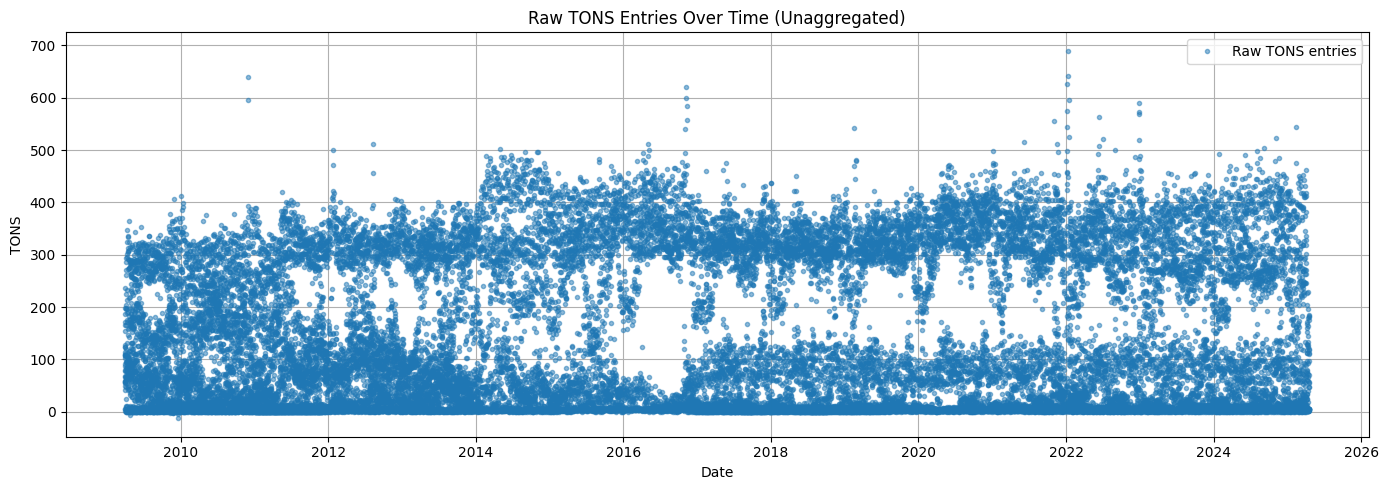

In [ ]:
# Assuming df is already loaded and Date is converted
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date just to be safe
df_sorted = df.sort_values('Date')

# Plot raw TONS entries
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df_sorted['Date'], df_sorted['TONS'], '.', alpha=0.5, label='Raw TONS entries')
plt.title('Raw TONS Entries Over Time (Unaggregated)')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Daily total TONS
daily = df.groupby('Date')['TONS'].sum().sort_index()

# Compute difference and ratio
daily_diff = daily.diff()
daily_ratio = daily / daily.shift(1)

# Find where the TONS suddenly increased a lot
spike_days = daily_ratio[daily_ratio > 2]  # Example threshold


<Axes: xlabel='Date'>

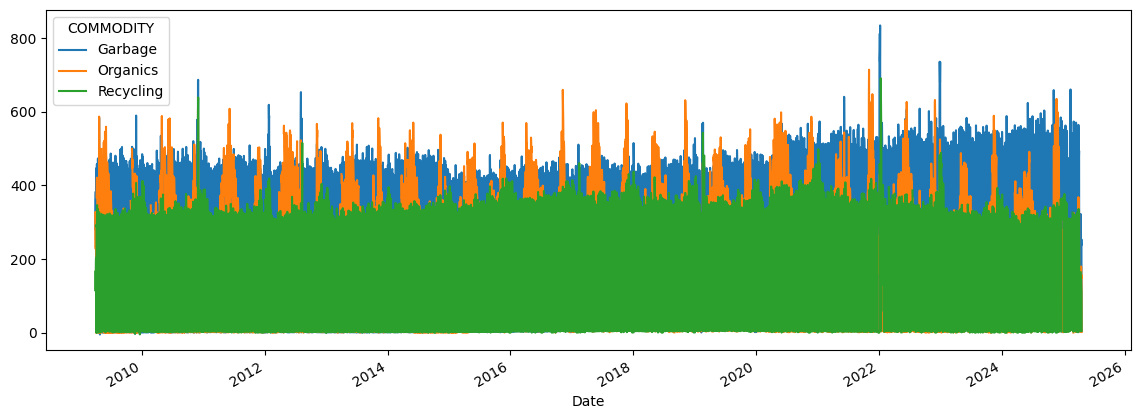

In [ ]:
commodity_daily = df.groupby(['Date', 'COMMODITY'])['TONS'].sum().unstack()
commodity_daily.plot(figsize=(14, 5))


<Axes: xlabel='Date'>

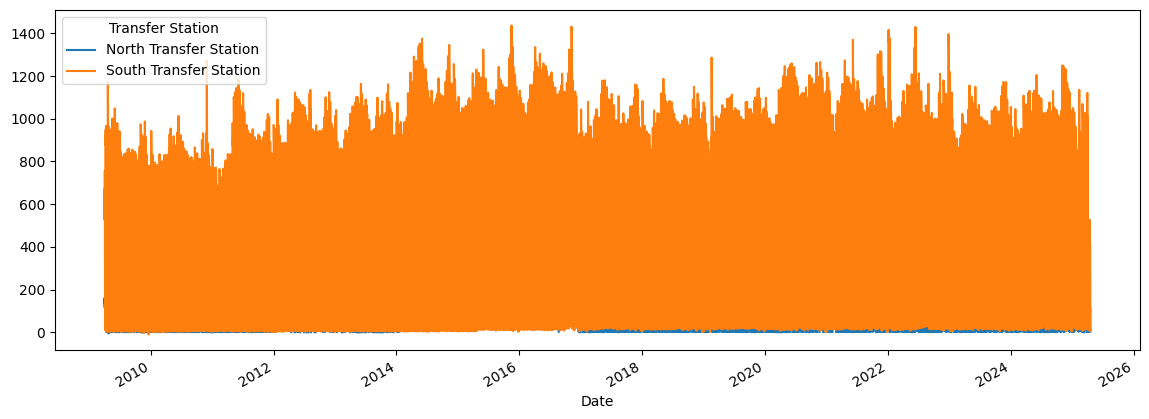

In [ ]:
station_daily = df.groupby(['Date', 'Transfer Station'])['TONS'].sum().unstack()
station_daily.plot(figsize=(14, 5))


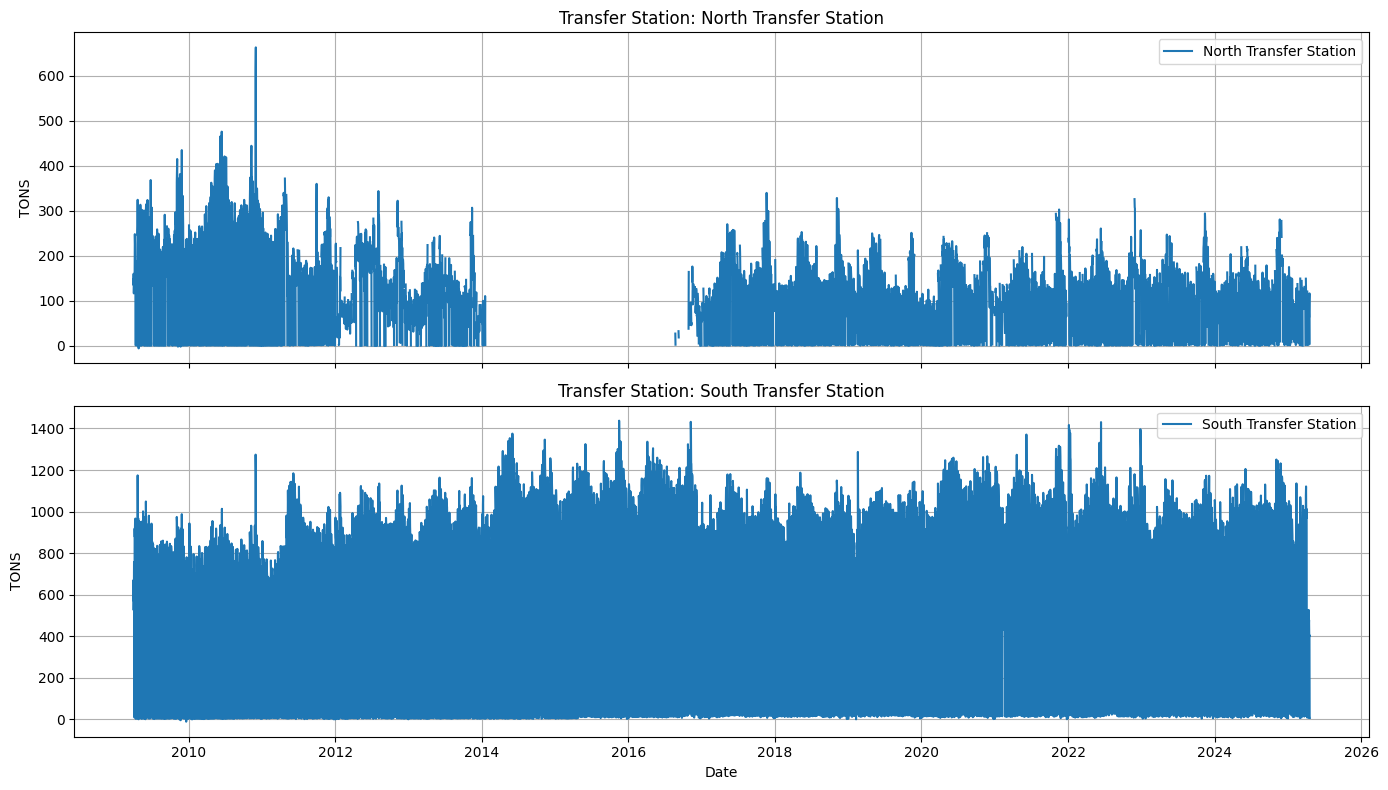

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Date' is datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df_sorted = df.sort_values('Date')

# Group by Date and Transfer Station, summing TONS
station_grouped = df_sorted.groupby(['Date', 'Transfer Station'])['TONS'].sum().unstack()

# Plot each station in its own subplot
fig, axs = plt.subplots(len(station_grouped.columns), 1, figsize=(14, 8), sharex=True)

for i, station in enumerate(station_grouped.columns):
    axs[i].plot(station_grouped.index, station_grouped[station], label=f'{station}', color='tab:blue')
    axs[i].set_ylabel('TONS')
    axs[i].set_title(f'Transfer Station: {station}')
    axs[i].grid(True)
    axs[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()


## Extra variables: weather variables
* Variables from meteostat provider - through API
* should run from 2009-03-31 to 2025-04-20
* it is aggregated to weekly frequency with a mean temperature
* the most `important variables` are probably:

  * `tavg` - average temperature
  * `prcp` - weekly sum of rain
  * `wspd` - average windspeed


In [ ]:
# Install meteostat (only needs to be run once)
!pip install meteostat

# Now import and run the script
from meteostat import Daily, Point
import pandas as pd
from datetime import datetime

# Define time period
start = datetime(2009, 3, 30)
end = datetime(2025, 4, 20)

# Define Seattle coordinates
seattle = Point(47.6062, -122.3321)

# Get daily weather data
data = Daily(seattle, start, end)
df = data.fetch()

# Resample to weekly frequency (mean values for each 7-day period)
weekly_weather = df.resample('W').agg({
    'tavg': 'mean',
    'prcp': 'sum',
    'tmin': 'mean',
    'tmax': 'mean',
    'snow': 'sum',
    'wspd': 'mean',
    'wpgt': 'mean',
    'pres': 'mean'
})

# Optional: Reset index for clarity
weekly_weather = weekly_weather.reset_index()

# Display first few rows
weekly_weather.head()
weekly_weather.tail()


,time,tavg,prcp,tmin,tmax,snow,wspd,wpgt,pres
833,2025-03-23,8.014286,47.2,4.871429,11.442857,0.0,13.442857,NaN,1017.314286
834,2025-03-30,11.914286,30.2,8.428571,15.957143,0.0,9.757143,NaN,1011.042857
835,2025-04-06,10.342857,20.7,6.428571,14.514286,0.0,6.614286,NaN,1017.014286
836,2025-04-13,10.257143,35.1,6.900000,14.300000,0.0,9.357143,NaN,1021.485714
837,2025-04-20,12.614286,10.5,7.785714,17.528571,0.0,7.228571,NaN,1020.271429


In [ ]:
weekly_weather.head()

,time,tavg,prcp,tmin,tmax,snow,wspd,wpgt,pres
0,2009-04-05,7.128571,41.2,3.014286,11.100000,0.0,11.214286,NaN,1018.257143
1,2009-04-12,10.414286,20.3,7.000000,13.900000,0.0,8.500000,NaN,1014.614286
2,2009-04-19,9.185714,14.1,4.742857,13.657143,0.0,8.000000,NaN,1024.071429
3,2009-04-26,10.471429,6.7,5.628571,15.242857,0.0,7.171429,NaN,1020.371429
4,2009-05-03,12.314286,12.5,7.614286,16.900000,0.0,7.985714,NaN,1016.942857


In [ ]:
# export weekly_df to a CSV file
weekly_weather.to_csv('seattle_weekly_weather.csv', index=False)

# Download the csv file
from google.colab import files
files.download('seattle_weekly_weather.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot of temperature

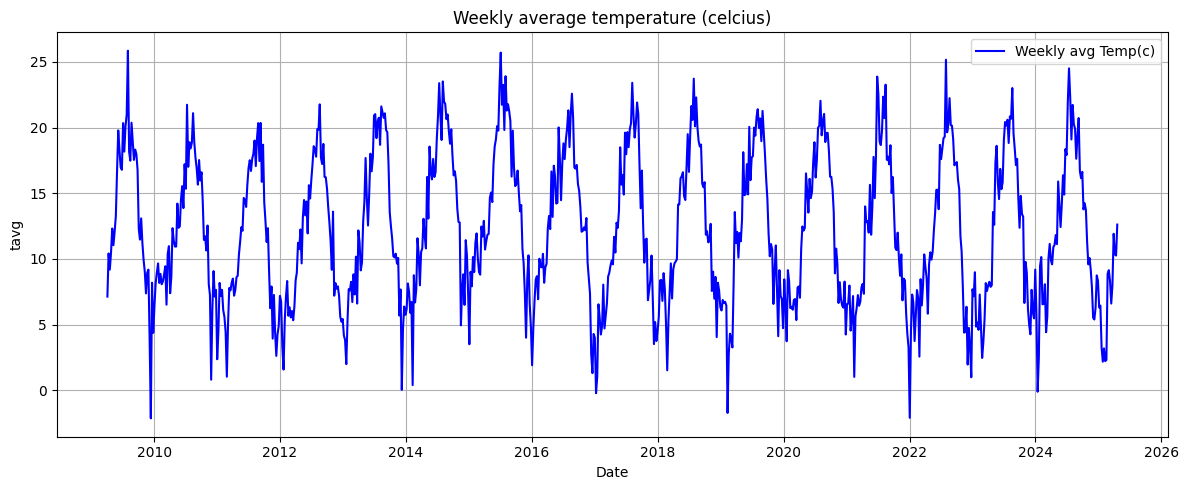

In [ ]:
import matplotlib.pyplot as plt

# Plot the weekly TONS time series
plt.figure(figsize=(12, 5))
plt.plot(weekly_weather['time'], weekly_weather['tavg'], label='Weekly avg Temp(c)', color='blue')
plt.title('Weekly average temperature (celcius)')
plt.xlabel('Date')
plt.ylabel('tavg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Plot of precipitation (Rain)

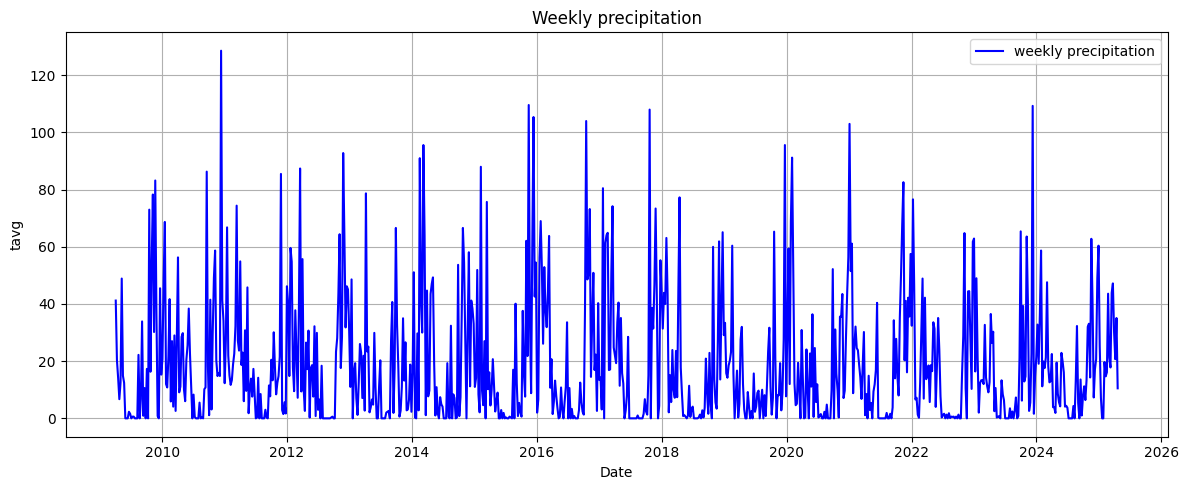

In [ ]:
import matplotlib.pyplot as plt

# Plot the weekly TONS time series
plt.figure(figsize=(12, 5))
plt.plot(weekly_weather['time'], weekly_weather['prcp'], label='weekly precipitation', color='blue')
plt.title('Weekly precipitation')
plt.xlabel('Date')
plt.ylabel('tavg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### unfinished plot of windspeed

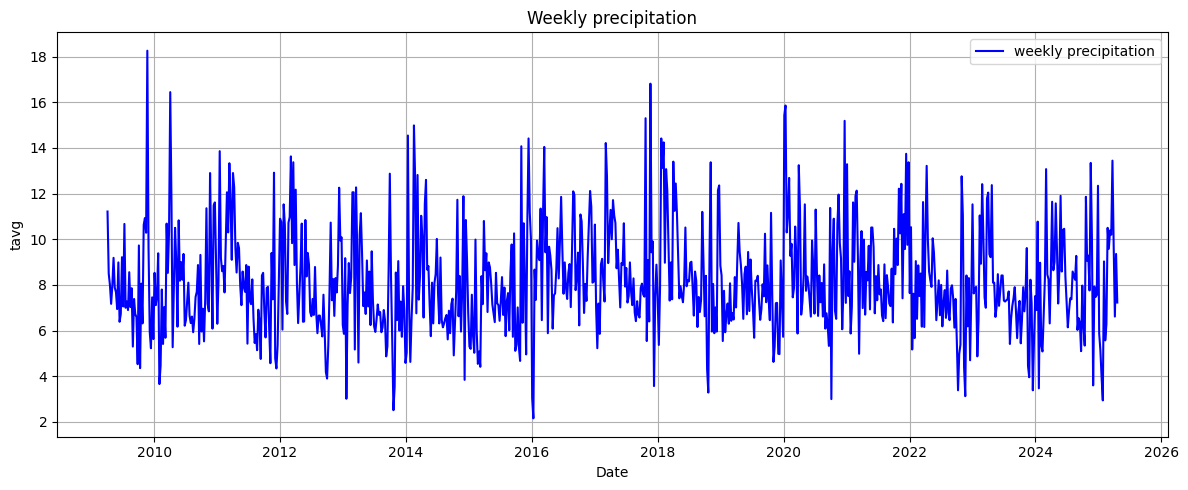

In [ ]:
import matplotlib.pyplot as plt

# Plot the weekly TONS time series
plt.figure(figsize=(12, 5))
plt.plot(weekly_weather['time'], weekly_weather['wspd'], label='weekly precipitation', color='blue')
plt.title('Weekly precipitation')
plt.xlabel('Date')
plt.ylabel('tavg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## ADF test, seasonal decomposition

### ADF test of unit root: weekly_tons

* H0: The series has a unit root - is non-stationary
* HA: The series does not have a unit root - is stationary

* If p-val < 0.05 significance level we can reject H0

In [ ]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_tons)
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")


ADF Statistic: -4.080294820265245, p-value: 0.0010437671096096754


We have evidence to reject H0 and infer that the series does not contain a unit root and is therefore likely stationary

### Seasonal decomposition of weekly_tons

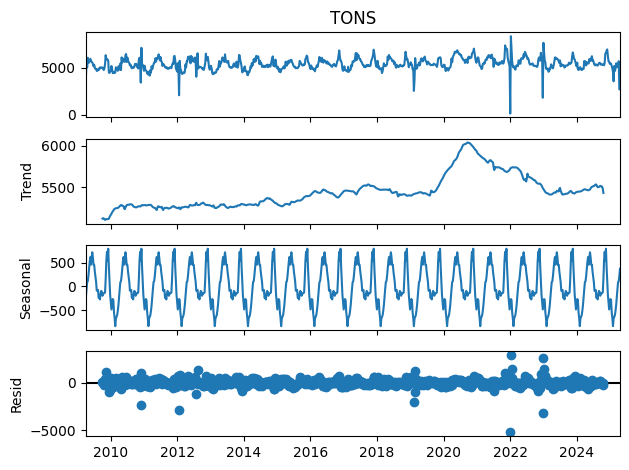

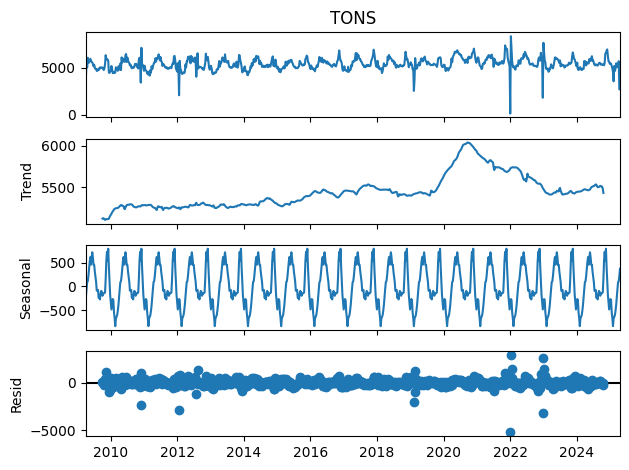

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(weekly_tons, model='additive', period=52).plot()


In [ ]:
weekly_tons.isna().sum()


np.int64(0)

## Feature engineering (merging of datasets into one)

* we want to merge weekly_tons with weekly_weather
* we also need to create lagged values of the tons

In [ ]:
# Create weekly data frame
weekly_df = pd.DataFrame({'TONS': weekly_tons})

# Add lags for TONS
weekly_df['lag_1'] = weekly_df['TONS'].shift(1)
weekly_df['lag_2'] = weekly_df['TONS'].shift(2)

# Align weather data with weekly index
weekly_weather.index = weekly_df.index

# Join weather data (only to create lagged weather features)
weekly_df = weekly_df.join(weekly_weather[['tavg', 'prcp', 'wspd']])

# Add 1-week lag for weather features
weekly_df['tavg_lag1'] = weekly_df['tavg'].shift(1)
weekly_df['prcp_lag1'] = weekly_df['prcp'].shift(1)
weekly_df['wspd_lag1'] = weekly_df['wspd'].shift(1)

# Drop unlagged weather variables (to prevent data leakage)
weekly_df.drop(columns=['tavg', 'prcp', 'wspd'], inplace=True)

# Drop rows with missing values (due to shifting)
weekly_df.dropna(inplace=True)

# Now weekly_df is clean and contains only valid forecasting features
# Columns: ['TONS', 'lag_1', 'lag_2', 'tavg_lag1', 'prcp_lag1', 'wspd_lag1']


In [ ]:

print(weekly_weather.index)



DatetimeIndex(['2009-04-05', '2009-04-12', '2009-04-19', '2009-04-26',
               '2009-05-03', '2009-05-10', '2009-05-17', '2009-05-24',
               '2009-05-31', '2009-06-07',
               ...
               '2025-02-16', '2025-02-23', '2025-03-02', '2025-03-09',
               '2025-03-16', '2025-03-23', '2025-03-30', '2025-04-06',
               '2025-04-13', '2025-04-20'],
              dtype='datetime64[ns]', length=838, freq='W-SUN')


In [ ]:
print(weekly_df.index)

DatetimeIndex(['2009-04-19', '2009-04-26', '2009-05-03', '2009-05-10',
               '2009-05-17', '2009-05-24', '2009-05-31', '2009-06-07',
               '2009-06-14', '2009-06-21',
               ...
               '2025-02-16', '2025-02-23', '2025-03-02', '2025-03-09',
               '2025-03-16', '2025-03-23', '2025-03-30', '2025-04-06',
               '2025-04-13', '2025-04-20'],
              dtype='datetime64[ns]', length=836, freq='W-SUN')


In [ ]:
#weekly_weather.head()
weekly_df.head()


,TONS,lag_1,lag_2,tavg_lag1,prcp_lag1,wspd_lag1
2009-04-19,5056.141010,5610.526417,3932.634451,10.414286,20.3,8.500000
2009-04-26,6075.933124,5056.141010,5610.526417,9.185714,14.1,8.000000
2009-05-03,5593.365713,6075.933124,5056.141010,10.471429,6.7,7.171429
2009-05-10,5555.788470,5593.365713,6075.933124,12.314286,12.5,7.985714
2009-05-17,5738.468889,5555.788470,5593.365713,11.042857,48.9,9.185714


In [ ]:
# inspect dataframe
print(weekly_df)

                   TONS        lag_1        lag_2  tavg_lag1  prcp_lag1  \
2009-04-19  5056.141010  5610.526417  3932.634451  10.414286       20.3   
2009-04-26  6075.933124  5056.141010  5610.526417   9.185714       14.1   
2009-05-03  5593.365713  6075.933124  5056.141010  10.471429        6.7   
2009-05-10  5555.788470  5593.365713  6075.933124  12.314286       12.5   
2009-05-17  5738.468889  5555.788470  5593.365713  11.042857       48.9   
...                 ...          ...          ...        ...        ...   
2025-03-23  5173.616571  5082.027874  5487.505849   6.600000       43.9   
2025-03-30  5304.368211  5173.616571  5082.027874   8.014286       47.2   
2025-04-06  5705.570603  5304.368211  5173.616571  11.914286       30.2   
2025-04-13  2717.142798  5705.570603  5304.368211  10.342857       20.7   
2025-04-20  2754.842907  2717.142798  5705.570603  10.257143       35.1   

            wspd_lag1  
2009-04-19   8.500000  
2009-04-26   8.000000  
2009-05-03   7.171429  
200

## Modelling
* A simple benchmark model - naive forecast
* ARIMA model
* ML

In [ ]:
# split data for ARIMA - 80% for training, 20% remains for testing
split_idx = int(len(weekly_tons)*0.8)

# chronological split
weekly_tons_train = weekly_tons.iloc[:split_idx]
weekly_tons_test = weekly_tons.iloc[split_idx:]

# iloc = integer location, a pandas method to select rows/columns by their
# integer position - e.g., df.iloc[0] - selects first row etc.

In [ ]:
# split dataframe for ML models - 80% train, 20% for testing
split_idx = int(len(weekly_df)*0.8) # same as above

x = weekly_df.drop(columns = ['TONS'])
y = weekly_df['TONS']

# chronological split
x_train = x.iloc[:split_idx]
x_test = x.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]


In [ ]:
y_test.head()

,TONS
2022-02-06,5024.411451
2022-02-13,5146.363253
2022-02-20,5106.794826
2022-02-27,4810.867789
2022-03-06,5149.972387


# Naive mean constant

Mean Naive RMSE: 668.38


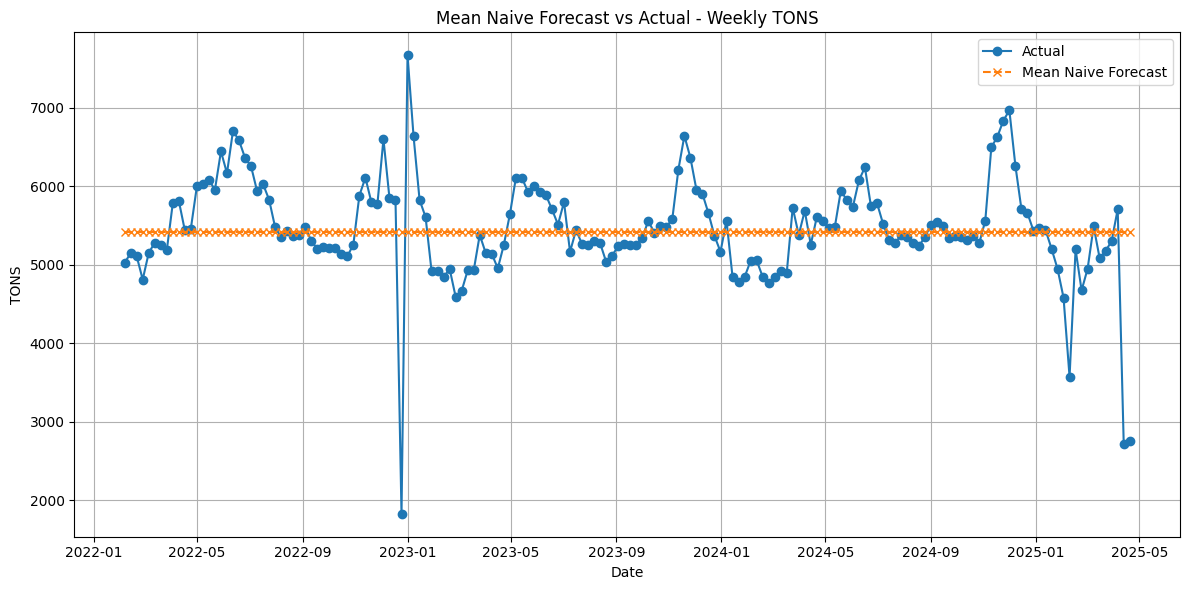

Training set mean (baseline forecast value): 5420.70


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Set global seed for full reproducibility (for any future use in this script)
np.random.seed(42)

# Mean Naive Forecast: use the mean of training values
train_mean = weekly_tons_train.mean()
mean_naive_forecast = np.repeat(train_mean, len(weekly_tons_test))

# Compute RMSE
mean_naive_rmse = np.sqrt(mean_squared_error(weekly_tons_test, mean_naive_forecast))
print(f"Mean Naive RMSE: {mean_naive_rmse:.2f}")

# Create a DataFrame for plotting
forecast_df = pd.DataFrame({
    'Actual': weekly_tons_test.values,
    'Mean Naive Forecast': mean_naive_forecast
}, index=weekly_tons_test.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Actual'], label='Actual', marker='o')
plt.plot(forecast_df.index, forecast_df['Mean Naive Forecast'], label='Mean Naive Forecast', linestyle='--', marker='x')
plt.title('Mean Naive Forecast vs Actual - Weekly TONS')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Training set mean (baseline forecast value): {train_mean:.2f}")


# ARIMA

# checking for ACF

<Figure size 1200x500 with 0 Axes>

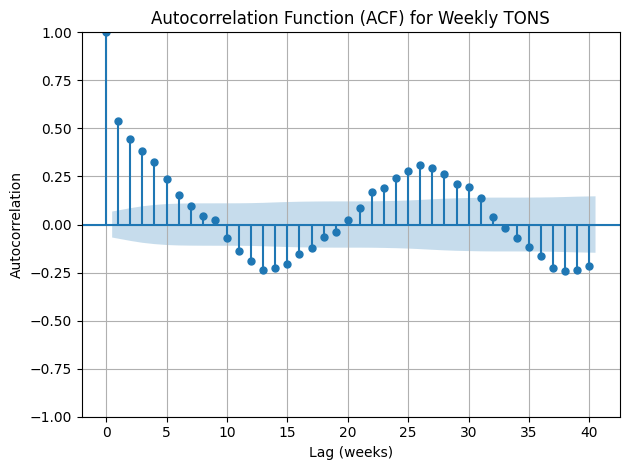

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the weekly TONS series
plt.figure(figsize=(12, 5))
plot_acf(weekly_tons, lags=40)  # you can adjust lags= to see more/less
plt.title('Autocorrelation Function (ACF) for Weekly TONS')
plt.xlabel('Lag (weeks)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()


# PACF

<Figure size 1200x500 with 0 Axes>

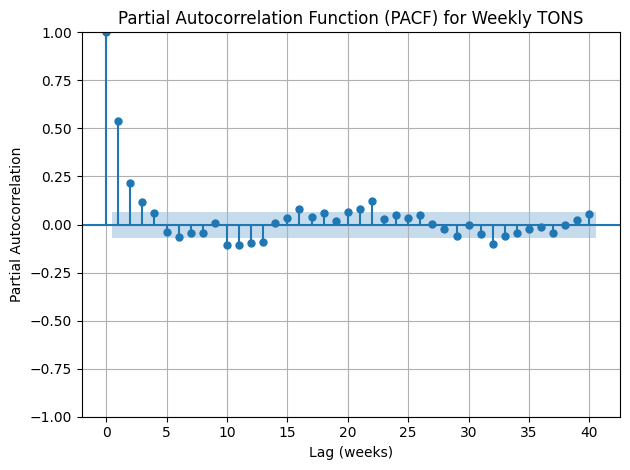

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF for the weekly TONS series
plt.figure(figsize=(12, 5))
plot_pacf(weekly_tons, lags=40, method='ywm')  # method='ywm' is stable for seasonal data
plt.title('Partial Autocorrelation Function (PACF) for Weekly TONS')
plt.xlabel('Lag (weeks)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

#ARIMA with 5 0 5 the best RMSE found from the search

ARIMA(5,0,5) RMSE: 590.84


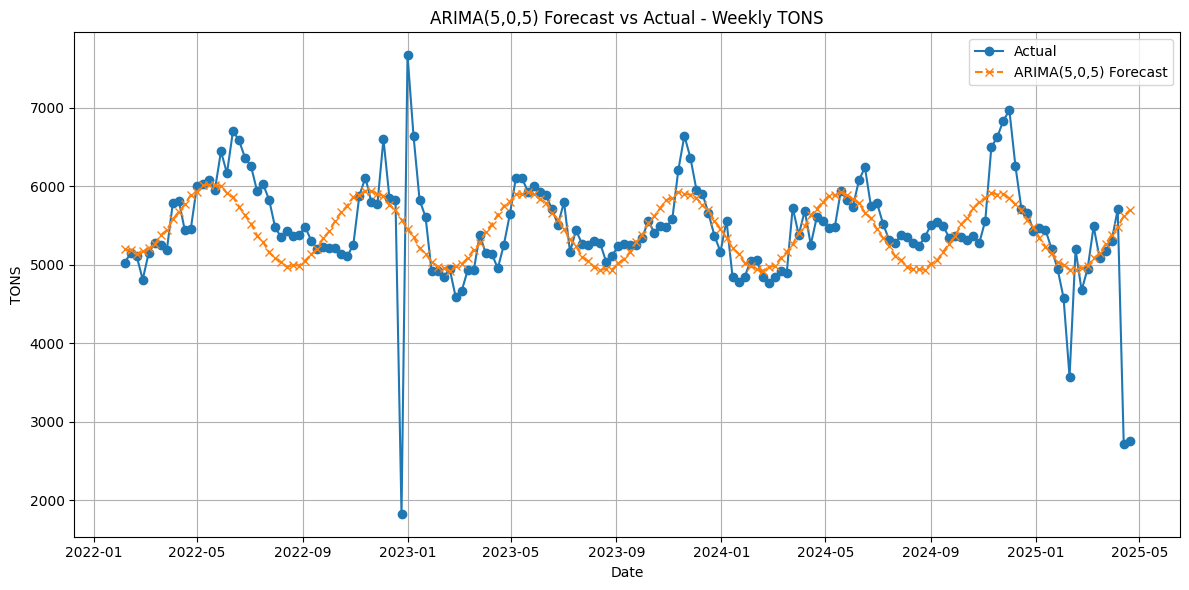

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set global seed for reproducibility
np.random.seed(42)

# Fit ARIMA(5,0,5)
model_505 = ARIMA(weekly_tons_train, order=(5, 0, 5))
model_505_fit = model_505.fit()

# Forecast
forecast_505 = model_505_fit.forecast(steps=len(weekly_tons_test))

# Evaluate RMSE
rmse_505 = np.sqrt(mean_squared_error(weekly_tons_test, forecast_505))
print(f"ARIMA(5,0,5) RMSE: {rmse_505:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_tons_test.index, weekly_tons_test, label='Actual', marker='o')
plt.plot(weekly_tons_test.index, forecast_505, label='ARIMA(5,0,5) Forecast', linestyle='--', marker='x')
plt.title('ARIMA(5,0,5) Forecast vs Actual - Weekly TONS')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SEARCH GRID FOR ARIMA

Best ARIMA order: (5, 0, 5)
Best RMSE: 590.84


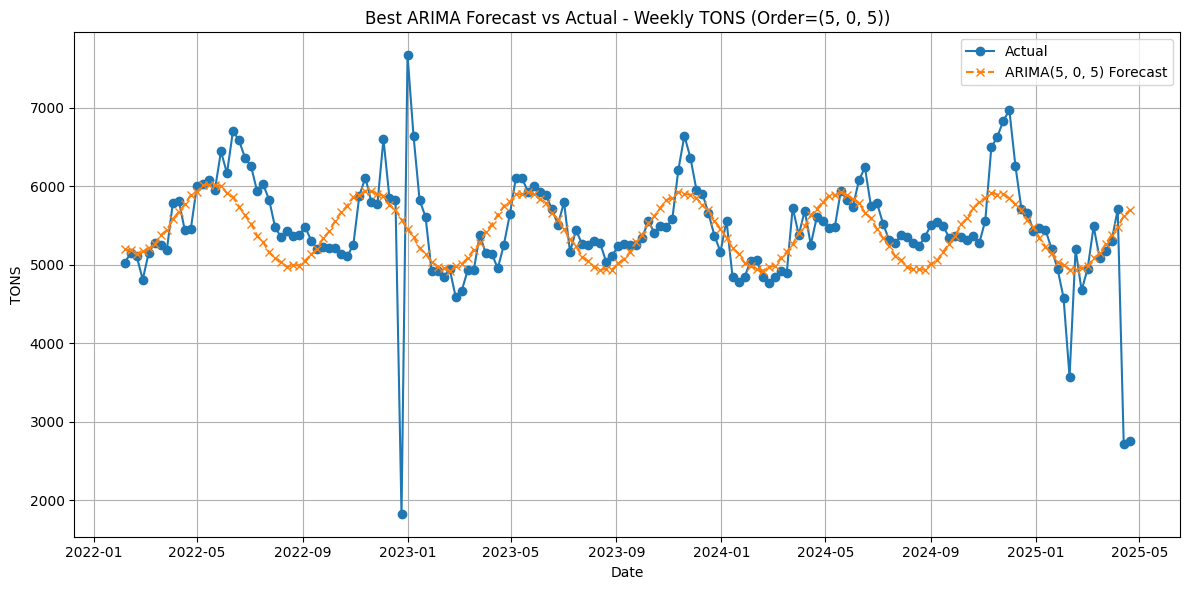

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set global seed for reproducibility
np.random.seed(42)

# Define search ranges
p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

best_rmse = float("inf")
best_order = None
best_forecast = None

# Grid search over (p, d, q)
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(weekly_tons_train, order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(weekly_tons_test))
                rmse = np.sqrt(mean_squared_error(weekly_tons_test, forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
                    best_forecast = forecast

            except:
                continue  # Skip invalid configurations

print(f"Best ARIMA order: {best_order}")
print(f"Best RMSE: {best_rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_tons_test.index, weekly_tons_test, label='Actual', marker='o')
plt.plot(weekly_tons_test.index, best_forecast, label=f'ARIMA{best_order} Forecast', linestyle='--', marker='x')
plt.title(f'Best ARIMA Forecast vs Actual - Weekly TONS (Order={best_order})')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Tuning for Gradient Boosting

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

 Best parameters found:
{'learning_rate': 0.03, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 200, 'subsample': 0.7}

 Test RMSE: 538.96
 Test R²: 0.3503


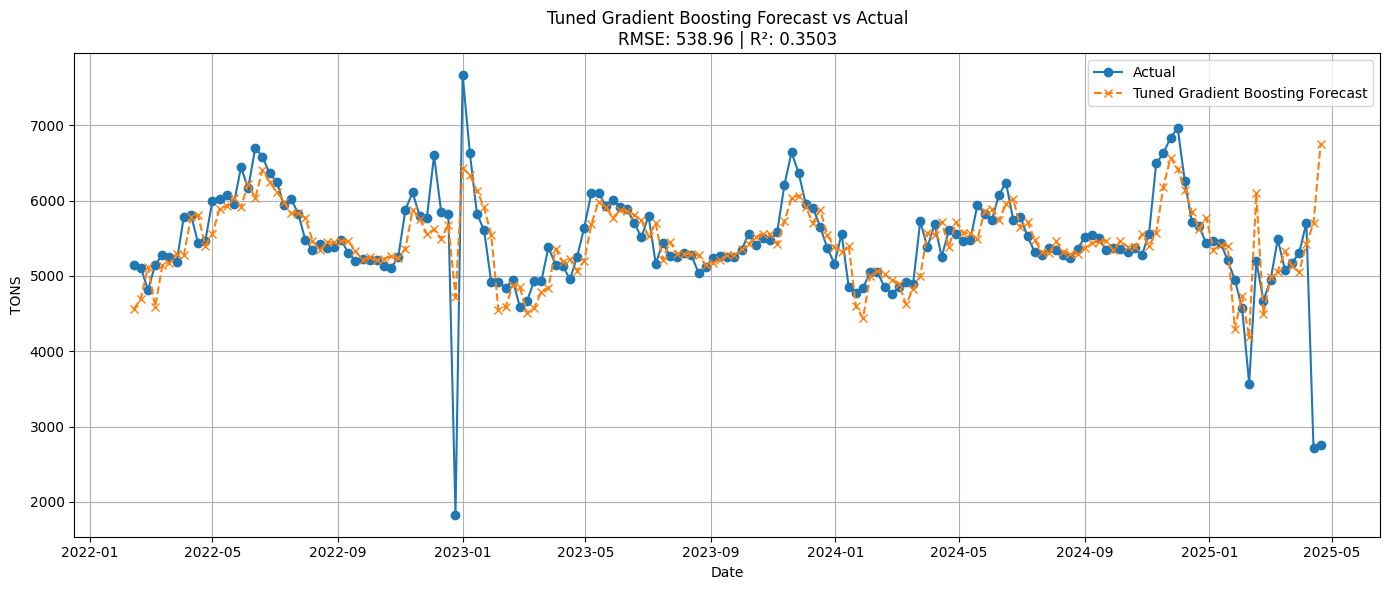

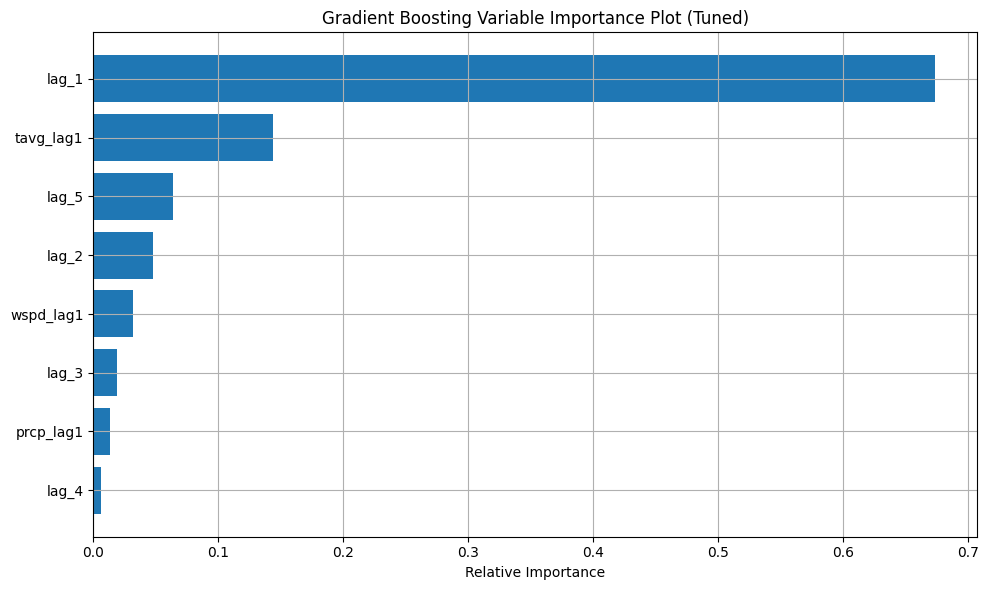


 Feature Importance Table:
     Feature  Importance
0      lag_1    0.673654
5  tavg_lag1    0.144247
4      lag_5    0.063537
1      lag_2    0.048207
7  wspd_lag1    0.031770
2      lag_3    0.019147
6  prcp_lag1    0.013511
3      lag_4    0.005927


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# Set reproducibility
SEED = 42
np.random.seed(SEED)

# Create lag features from TONS (lags 1 to 5)
for lag in range(1, 6):
    weekly_df[f'lag_{lag}'] = weekly_df['TONS'].shift(lag)

# Drop rows with NaNs due to lagging
weekly_df.dropna(inplace=True)

# Define features
feature_cols = [f'lag_{i}' for i in range(1, 6)] + ['tavg_lag1', 'prcp_lag1', 'wspd_lag1']
x = weekly_df[feature_cols]
y = weekly_df['TONS']

# Chronological 80/20 split
split_idx = int(len(weekly_df) * 0.8)
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# hyperparameter grid
param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [3, 5, 7],
    'subsample': [0.7, 0.85, 1.0]
}

# TimeSeriesSplit for proper CV
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=SEED),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(x_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("\n Best parameters found:")
print(grid_search.best_params_)

# Evaluate on test set
y_pred = best_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Test RMSE: {rmse:.2f}")
print(f" Test R²: {r2:.4f}")

# Forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Tuned Gradient Boosting Forecast', linestyle='--', marker='x')
plt.title(f'Tuned Gradient Boosting Forecast vs Actual\nRMSE: {rmse:.2f} | R²: {r2:.4f}')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# VIP Plot
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Gradient Boosting Variable Importance Plot (Tuned)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

# Print table
print("\n Feature Importance Table:")
print(importance_df.sort_values(by='Importance', ascending=False))


# Gradient Boosting (using 5 lags)



 Test RMSE: 513.71
 Test R²: 0.4125


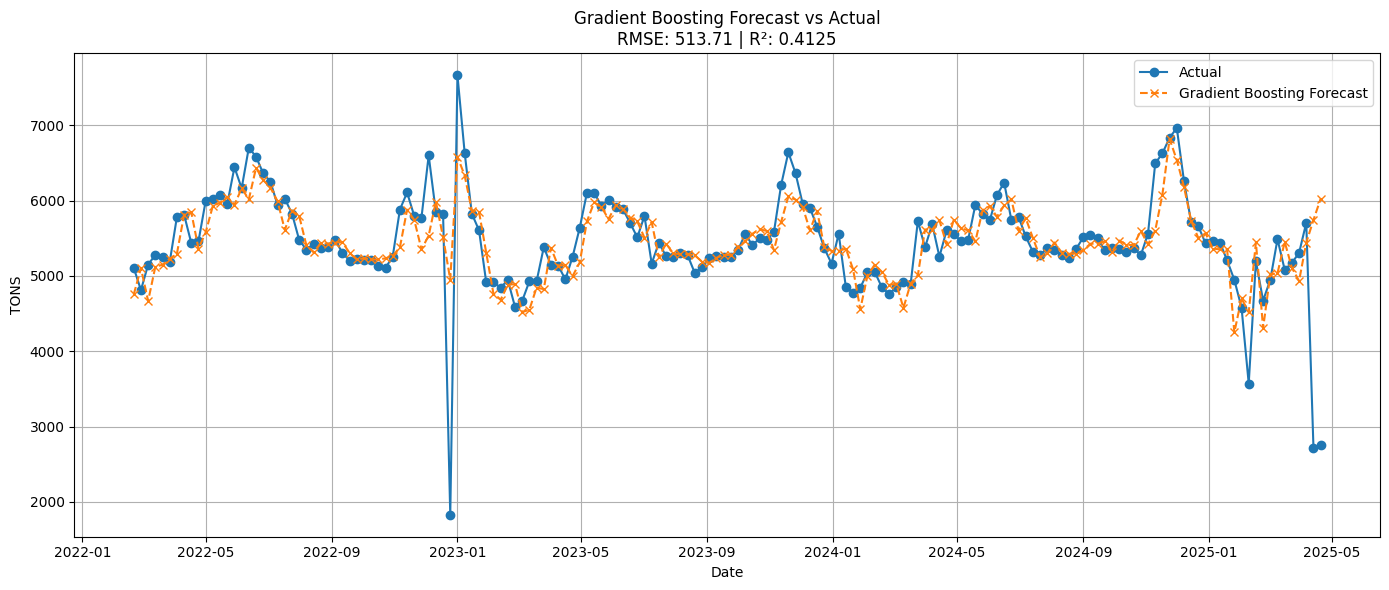

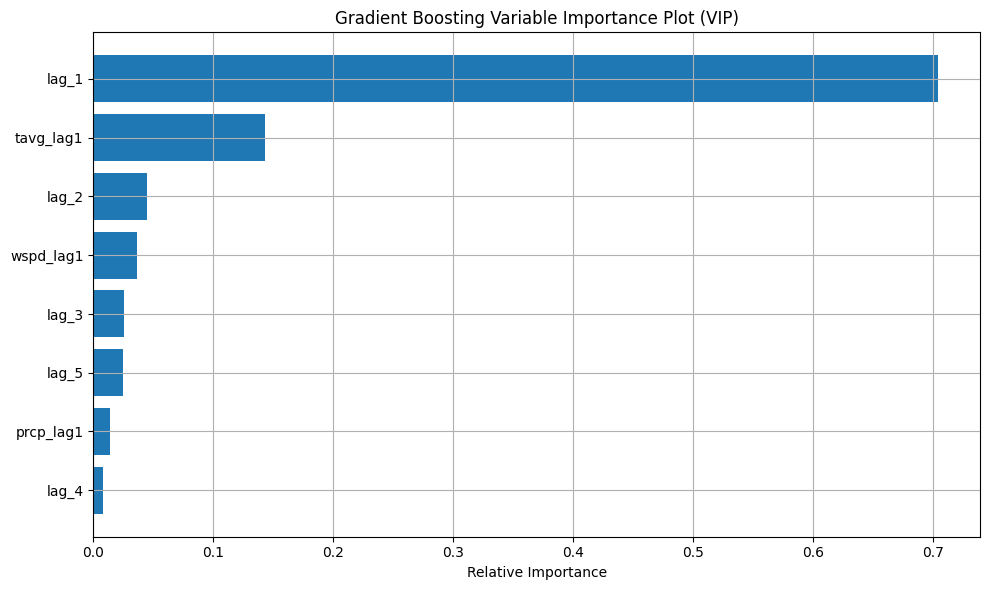


🔍 Feature Importance Table:
     Feature  Importance
0      lag_1    0.704119
5  tavg_lag1    0.143101
1      lag_2    0.044699
7  wspd_lag1    0.036188
2      lag_3    0.025265
4      lag_5    0.024606
6  prcp_lag1    0.014014
3      lag_4    0.008009


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set reproducibility
SEED = 42
np.random.seed(SEED)

# Create lag features from TONS (lags 1 to 5)
for lag in range(1, 6):
    weekly_df[f'lag_{lag}'] = weekly_df['TONS'].shift(lag)

# Drop rows with NaNs due to lagging
weekly_df.dropna(inplace=True)

# Define features (include lag_1 to lag_5 + weather-related features)
feature_cols = [f'lag_{i}' for i in range(1, 6)] + ['tavg_lag1', 'prcp_lag1', 'wspd_lag1']
x = weekly_df[feature_cols]
y = weekly_df['TONS']

# 80/20 chronological split
split_idx = int(len(weekly_df) * 0.8)
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train with best parameters
model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=5,
    n_estimators=100,
    subsample=1,
    random_state=SEED
)

model.fit(x_train, y_train)

# Predict and evaluate
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Test RMSE: {rmse:.2f}")
print(f" Test R²: {r2:.4f}")

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Gradient Boosting Forecast', linestyle='--', marker='x')
plt.title(f'Gradient Boosting Forecast vs Actual\nRMSE: {rmse:.2f} | R²: {r2:.4f}')
plt.xlabel('Date')
plt.ylabel('TONS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Variable Importance Plot (VIP)
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Gradient Boosting Variable Importance Plot (VIP)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

# Optional: print table
print("\n🔍 Feature Importance Table:")
print(importance_df.sort_values(by='Importance', ascending=False))


#3 plots for showing the comparison

Mean Naive RMSE: 668.38


ARIMA(5,0,5) RMSE: 590.84
Gradient Boosting RMSE (with lags): 507.61
Gradient Boosting R² (with lags): 0.4289


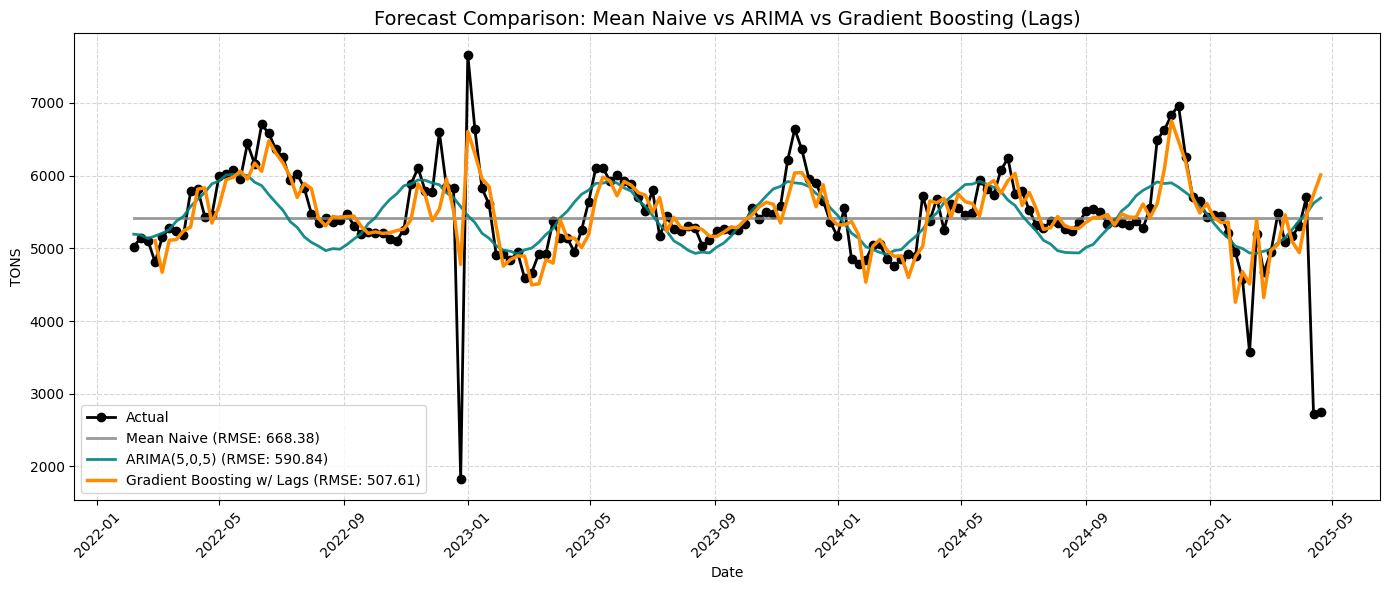

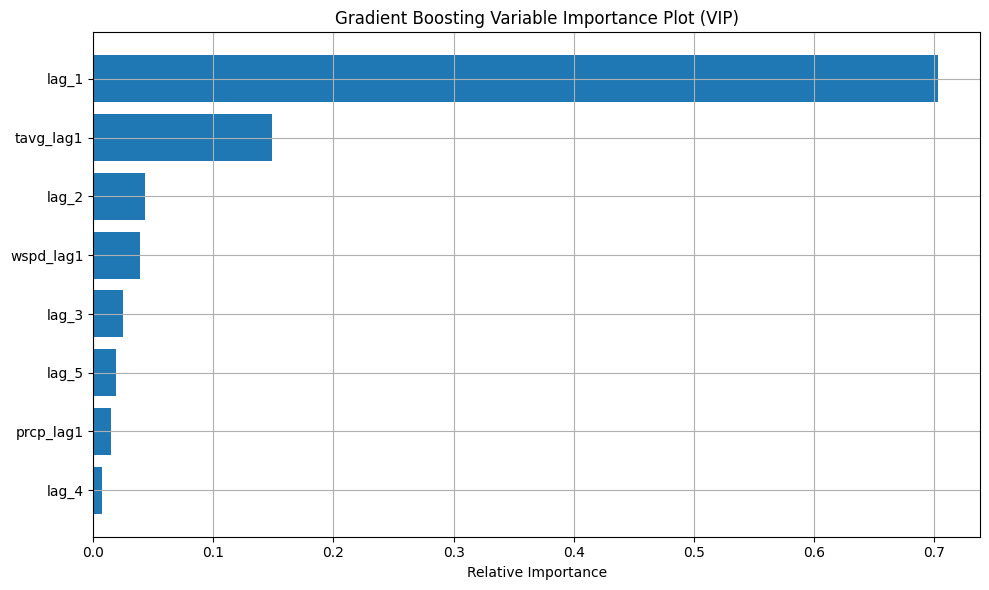


 Feature Importance Table:
     Feature  Importance
0      lag_1    0.702991
5  tavg_lag1    0.148529
1      lag_2    0.043471
7  wspd_lag1    0.039068
2      lag_3    0.024404
4      lag_5    0.019332
6  prcp_lag1    0.014495
3      lag_4    0.007708


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# --- SETUP ---
SEED = 42
np.random.seed(SEED)

# --- MEAN NAIVE FORECAST ---
train_mean = weekly_tons_train.mean()
mean_naive_forecast = np.repeat(train_mean, len(weekly_tons_test))
mean_naive_rmse = np.sqrt(mean_squared_error(weekly_tons_test, mean_naive_forecast))
print(f"Mean Naive RMSE: {mean_naive_rmse:.2f}")

# --- ARIMA(5,0,5) FORECAST ---
model_505 = ARIMA(weekly_tons_train, order=(5, 0, 5))
model_505_fit = model_505.fit()
forecast_505 = model_505_fit.forecast(steps=len(weekly_tons_test))
rmse_505 = np.sqrt(mean_squared_error(weekly_tons_test, forecast_505))
print(f"ARIMA(5,0,5) RMSE: {rmse_505:.2f}")

# --- GRADIENT BOOSTING WITH LAGS 1–5 ---
# Create lag features
for lag in range(1, 6):
    weekly_df[f'lag_{lag}'] = weekly_df['TONS'].shift(lag)

weekly_df.dropna(inplace=True)

feature_cols = [f'lag_{i}' for i in range(1, 6)] + ['tavg_lag1', 'prcp_lag1', 'wspd_lag1']
x = weekly_df[feature_cols]
y = weekly_df['TONS']

split_idx = int(len(weekly_df) * 0.8)
x_train, x_test = x.iloc[:split_idx], x.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=5,
    n_estimators=100,
    subsample=1,
    random_state=SEED
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
rmse_gboost = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gboost = r2_score(y_test, y_pred)
print(f"Gradient Boosting RMSE (with lags): {rmse_gboost:.2f}")
print(f"Gradient Boosting R² (with lags): {r2_gboost:.4f}")

# --- UNIFIED PLOT ---
plt.figure(figsize=(14, 6))
plt.plot(weekly_tons_test.index, weekly_tons_test.values,
         label='Actual', color='black', linestyle='-', marker='o', linewidth=2)

plt.plot(weekly_tons_test.index, mean_naive_forecast,
         label=f'Mean Naive (RMSE: {mean_naive_rmse:.2f})',
         color='grey', linewidth=2, alpha=0.8)

plt.plot(weekly_tons_test.index, forecast_505,
         label=f'ARIMA(5,0,5) (RMSE: {rmse_505:.2f})',
         color='teal', linewidth=2, alpha=0.9)

plt.plot(y_test.index, y_pred,
         label=f'Gradient Boosting w/ Lags (RMSE: {rmse_gboost:.2f})',
         color='darkorange', linewidth=2.5)

plt.title('Forecast Comparison: Mean Naive vs ARIMA vs Gradient Boosting (Lags)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('TONS')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- VARIABLE IMPORTANCE PLOT ---
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Gradient Boosting Variable Importance Plot (VIP)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

# Optional: print table
print("\n Feature Importance Table:")
print(importance_df.sort_values(by='Importance', ascending=False))


# Table with results

In [ ]:
# --- MODEL PERFORMANCE TABLE ---
performance_df = pd.DataFrame({
    'Model': [
        'Mean Naive',
        'ARIMA(5,0,5)',
        'Gradient Boosting (lags 1–5)'
    ],
    'Test RMSE': [
        round(mean_naive_rmse, 2),
        round(rmse_505, 2),
        round(rmse_gboost, 2)
    ],
    'Test R²': [
        None,
        None,
        round(r2_gboost, 4)
    ]
})

print("\n Model Performance Summary:")
print(performance_df.to_string(index=False))



 Model Performance Summary:
                       Model  Test RMSE  Test R²
                  Mean Naive     668.38      NaN
                ARIMA(5,0,5)     590.84      NaN
Gradient Boosting (lags 1–5)     507.61   0.4289
